In [1]:
schema = 'ds_data_for_complexity'

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

import geohash2
import json

In [3]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [5]:
folder_name = f'dedicated.{schema}'
stops_table_name = f'dedicated.{schema}.selected_stops_limited'
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_subsampled'
dev_loc_model = f'dedicated.{schema}.device_location_and_stops_for_model_part3_geo8_space_time_vers2'

dev_loc_model = f'dedicated.{schema}.device_location_and_stops_forreal_forreal'


In [8]:
lineage_id = 9223372032225847377
date = 20240315

In [9]:
device_loc_stops = sql_engine.read_sql(f"""
select *
from {dev_loc_model}
where lineage_id = {lineage_id}
    and event_date = {date}
""")#[['lineage_id','event_timestamp','lat','lng','geohash_level_8','stop_class', 'stop_id']]

device_loc_stops['datetime'] = pd.to_datetime(device_loc_stops['event_timestamp'], unit='s')

In [10]:
stops = sql_engine.read_sql(f"""
select *, substr(geohash, 1, 8) AS geohash_level_8
from {stops_table_name}
where lineage_id = {lineage_id}
    and event_date = {date}
    and id_type != 'GAID'  
""")[['lineage_id', 'stop_id','stop_start_unix_timestamp','dwell_time_minutes','geohash_level_8','lat','lng']]
stop_geohashes = stops.drop(columns=['lat','lng']).copy()

In [11]:
device_loc_stops[['num_of_individual_stops_last_hour']].sum()

num_of_individual_stops_last_hour    6
dtype: int64

In [12]:
def geohash_to_geojson(geohash):
    # Decode the geohash to get the bounding box
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(geohash)
    lat_min = lat - lat_err
    lat_max = lat + lat_err
    lon_min = lon - lon_err
    lon_max = lon + lon_err

    # Create the GeoJSON polygon
    polygon = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [lon_min, lat_min],
                [lon_min, lat_max],
                [lon_max, lat_max],
                [lon_max, lat_min],
                [lon_min, lat_min]
            ]]
        },
        "properties": {
            "geohash": geohash
        }
    }
    return polygon

stop_geohashes['geojson'] = stop_geohashes['geohash_level_8'].apply(geohash_to_geojson)

In [13]:
# 1. Create Layer Configuration (Simplified)
layer_config_points = {
     'type': 'point',
     'config': {'dataId': 'Points',
      'label': 'Points',
      'color': [255, 0, 0],
      'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 3,
       'fixedRadius': False,
       'opacity': 0.5,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'filled': True},
      'hidden': False}
}
layer_config_stops = {
     'type': 'point',
     'config': {'dataId': 'Stops',
      'label': 'Stops',
      'color': [0, 200, 0],
      'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.2,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'filled': True},
      'hidden': False}
}
layer_config_stops_geohash = {
     'type': 'geojson',
     'config': {'dataId': 'Geohash',
      'label': 'Geohash',
      'color': [255, 254, 230],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [255, 153, 31],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'hidden': False}
}
# 2. Construct Kepler.gl Configuration
keplergl_config = {
    'version': 'v1',
    'config': {
        'visState': {
            'layers': [layer_config_stops_geohash, layer_config_stops, layer_config_points]
        }
    }
}


In [14]:
map_towrite = KeplerGl(height=600, config= keplergl_config)
map_towrite.add_data(stop_geohashes, name='Geohash')
map_towrite.add_data(stops, name='Stops')
map_towrite.add_data(device_loc_stops, name='Points')

map_towrite

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/srv/conda/envs/notebook/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'layers': [{'type': 'geojson', 'config': {'dataId': …

### Analyze time between points

In [15]:
query = f"""
WITH time_table AS (
    SELECT
        *,
        LEAD(event_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY event_timestamp) AS next_timestamp,
        LAG(event_timestamp) OVER (PARTITION BY lineage_id, data_provider, id_type ORDER BY event_timestamp) AS previous_timestamp
        
    FROM {dev_loc_model}
    where lineage_id % 100 = 0
)

SELECT
    *,
    (cast(next_timestamp as double) - cast(previous_timestamp as double)) / 60.0 AS difference_in_minutes
FROM time_table
order by lineage_id, event_timestamp
"""

df_sampling_rate = sql_engine.read_sql(query)

In [16]:
df_stop = df_sampling_rate[df_sampling_rate.stop_id.notnull() & df_sampling_rate.difference_in_minutes.notnull()].copy()
df_stop['difference_in_minutes'] = df_stop['difference_in_minutes'].astype(float)
df_stop['difference_in_minutes'].describe()

count    21111.000000
mean        65.282386
std        155.663195
min          0.000000
25%          1.850000
50%         12.950000
75%        118.000000
max       6091.233333
Name: difference_in_minutes, dtype: float64

In [17]:
df_not_stop = df_sampling_rate[df_sampling_rate.stop_id.isnull() & df_sampling_rate.difference_in_minutes.notnull()].copy()
df_not_stop['difference_in_minutes'] = df_not_stop['difference_in_minutes'].astype(float)
df_not_stop['difference_in_minutes'].describe()

count    363004.000000
mean          3.698972
std         104.377726
min           0.000000
25%           0.066667
50%           0.116667
75%           0.200000
max       18580.600000
Name: difference_in_minutes, dtype: float64

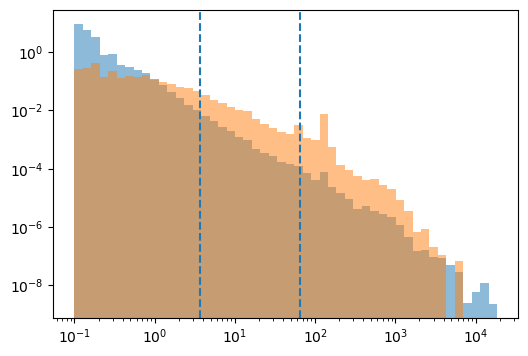

In [18]:
fig,ax = plt.subplots(figsize=(6,4), sharey=True)

def plot_loghist(x, bins, ax):
    logbins = np.logspace(np.log10(bins[0]+0.1),np.log10(bins[-1]),len(bins))
    ax.hist(x, bins=logbins, density=True, alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axvline(x.mean(), linestyle='--')

hist, bins = np.histogram(df_not_stop['difference_in_minutes'], bins=50)

plot_loghist(df_not_stop['difference_in_minutes'], bins, ax)
plot_loghist(df_stop['difference_in_minutes'], bins, ax)



## Analyze features

In [28]:
query = f"""
SELECT substr(geohash, 1, 6) AS geohash_level, AVG(COALESCE(geohash_entropy,0)) as feature
FROM {dev_loc_model}
group by substr(geohash, 1, 6)
"""
df_dev_loc_model = sql_engine.read_sql(query)

array([[<AxesSubplot: title={'center': 'feature'}>]], dtype=object)

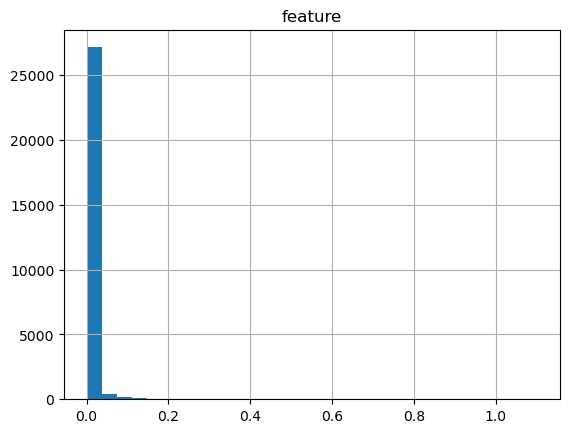

In [29]:
df_dev_loc_model['feature'] = df_dev_loc_model['feature'].clip(upper=5) 
df_dev_loc_model.hist(bins=30)

In [30]:
df_dev_loc_model['geojson'] = df_dev_loc_model['geohash_level'].apply(geohash_to_geojson)

In [31]:
map_towrite = KeplerGl(height=600, config = map_towrite.config)
map_towrite.add_data(df_dev_loc_model, name='Geohash')

map_towrite

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '6qyxd6i', 'type': …

In [33]:
# columns
query = f"""
    SELECT *
    FROM {dev_loc_model}
    limit 10
"""
result = sql_engine.read_sql(query)

In [34]:
# proportion of stops
lower = 0
higher = 2
bins = 100

query = f"""
    WITH ratio_stops AS(
    SELECT lineage_id, CAST(num_of_individual_stops_last_week AS double)/NULLIF(num_of_collective_stops_last_week,0) AS proportion_stops
    FROM {dev_loc_model}
    )
    SELECT WIDTH_BUCKET(proportion_stops ,{lower}, {higher}, {bins}) AS stops_bins,
        {lower} + ( WIDTH_BUCKET(proportion_stops ,{lower}, {higher}, {bins}) - 1 ) * (CAST({higher} as double)-{lower})/{bins} AS stops_values,
        COUNT(*) AS num_rows
    FROM ratio_stops
    GROUP BY WIDTH_BUCKET(proportion_stops ,{lower}, {higher}, {bins})
    ORDER BY WIDTH_BUCKET(proportion_stops ,{lower}, {higher}, {bins})
"""
result = sql_engine.read_sql(query).sort_values('stops_bins')

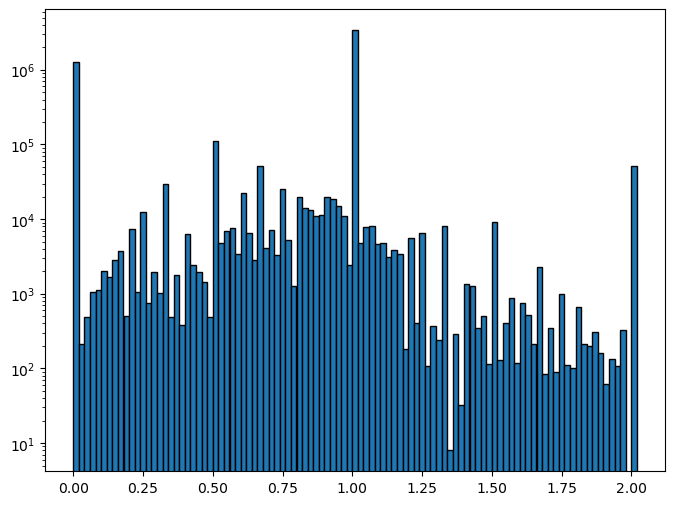

In [35]:
fig,ax = plt.subplots(figsize=(8,6))
ax.bar(result['stops_values'], result['num_rows'], width = (higher-lower)/(bins+1), edgecolor='k', align='edge')
ax.set_yscale('log')

In [36]:
query = f"""
    SELECT num_of_individual_stops_last_week, num_of_collective_stops_last_week, CAST(num_of_individual_stops_last_week AS double)/NULLIF(num_of_collective_stops_last_week,0) as ratio
    FROM {dev_loc_model}
    WHERE num_of_collective_stops_last_week IS NOT NULL
    limit 100000
"""
result = sql_engine.read_sql(query)

In [37]:
result[result['ratio']==1.5]

,num_of_individual_stops_last_week,num_of_collective_stops_last_week,ratio
2254,3,2,1.5
29543,12,8,1.5
71564,3,2,1.5
71566,3,2,1.5
71567,3,2,1.5
71568,3,2,1.5
71569,3,2,1.5
73021,3,2,1.5


In [40]:
query = f"""
    WITH ratio_stops AS(
    SELECT *, cast(num_of_individual_stops_last_week as double)/NULLIF(num_of_collective_stops_last_week,0) AS proportion_stops
    FROM {dev_loc_model}
    )
    SELECT proportion_stops
    FROM ratio_stops
    WHERE proportion_stops IS NOT NULL
    limit 100000
"""
result = sql_engine.read_sql(query)

array([[<AxesSubplot: title={'center': 'proportion_stops'}>]],
      dtype=object)

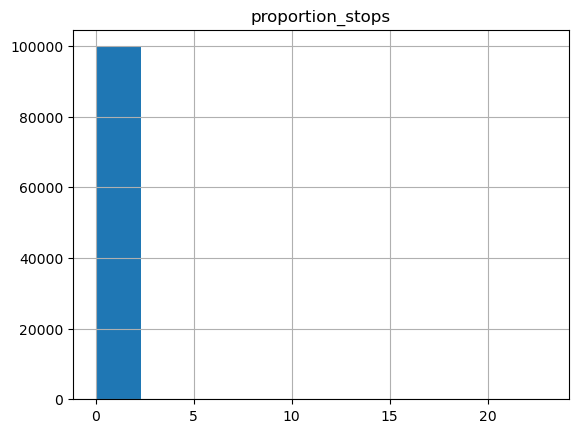

In [41]:
result.hist()